In [1]:
# Importing necessary libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re


## Project 1 - NLP and Text Classification

For this project you will need to classify some angry comments into their respective category of angry. The process that you'll need to follow is (roughly):
<ol>
<li> Use NLP techniques to process the training data. 
<li> Train model(s) to predict which class(es) each comment is in.
    <ul>
    <li> A comment can belong to any number of classes, including none. 
    </ul>
<li> Generate predictions for each of the comments in the test data. 
<li> Write your test data predicitions to a CSV file, which will be scored. 
</ol>

You can use any models and NLP libraries you'd like. Think aobut the problem, look back to see if there's anything that might help, give it a try, and see if that helps. We've regularly said we have a "toolkit" of things that we can use, we generally don't know which ones we'll need, but here you have a pretty simple goal - if it makes it more accurate, it helps. There's not one specific solution here, there are lots of things that you could do. 

## Training Data

Use the training data to train your prediction model(s). Each of the classification output columns (toxic to the end) is a human label for the comment_text, assessing if it falls into that category of "rude". A comment may fall into any number of categories, or none at all. Membership in one output category is <b>independent</b> of membership in any of the other classes (think about this when you plan on how to make these predictions - it may also make it easier to split work amongst a team...). 

In [2]:
train_df = pd.read_csv("train.csv.zip")
train_df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [3]:
train_df["non_toxic"] = train_df.iloc[:,2:8].apply(lambda x: 1 if (sum(x)==0) else 0, axis=1)
train_df.head(10)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,non_toxic
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,1
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,1
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,1
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,1
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,1
5,00025465d4725e87,"""\n\nCongratulations from me as well, use the ...",0,0,0,0,0,0,1
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0,0
7,00031b1e95af7921,Your vandalism to the Matt Shirvington article...,0,0,0,0,0,0,1
8,00037261f536c51d,Sorry if the word 'nonsense' was offensive to ...,0,0,0,0,0,0,1
9,00040093b2687caa,alignment on this subject and which are contra...,0,0,0,0,0,0,1


In [4]:
total={}
for col in train_df.iloc[:,2:].columns:
    total[col]=train_df[col].value_counts()[1]
    print(f"{col}: {total[col]}\n")

toxic: 15294

severe_toxic: 1595

obscene: 8449

threat: 478

insult: 7877

identity_hate: 1405

non_toxic: 143346



In [5]:
train_df['classes']=train_df.iloc[:,2:8].sum(axis=1)
train_df

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,non_toxic,classes
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,1,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,1,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,1,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,1,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...
159566,ffe987279560d7ff,""":::::And for the second time of asking, when ...",0,0,0,0,0,0,1,0
159567,ffea4adeee384e90,You should be ashamed of yourself \n\nThat is ...,0,0,0,0,0,0,1,0
159568,ffee36eab5c267c9,"Spitzer \n\nUmm, theres no actual article for ...",0,0,0,0,0,0,1,0
159569,fff125370e4aaaf3,And it looks like it was actually you who put ...,0,0,0,0,0,0,1,0


In [6]:
label_totals={}
for label in train_df['classes'].unique():
    label_totals[label]=train_df['classes'].value_counts()[label]

label_totals

{0: 143346, 4: 1760, 1: 6360, 3: 4209, 2: 3480, 5: 385, 6: 31}

In [7]:
keys=[key for key in label_totals.keys()]
values=[key for key in label_totals.values()]
keys1=keys.copy()
values1=values.copy()
keys1.pop(0)
values1.pop(0)

143346

Text(0.5, 1.0, 'Plot excluding unlabeled(0) comments')

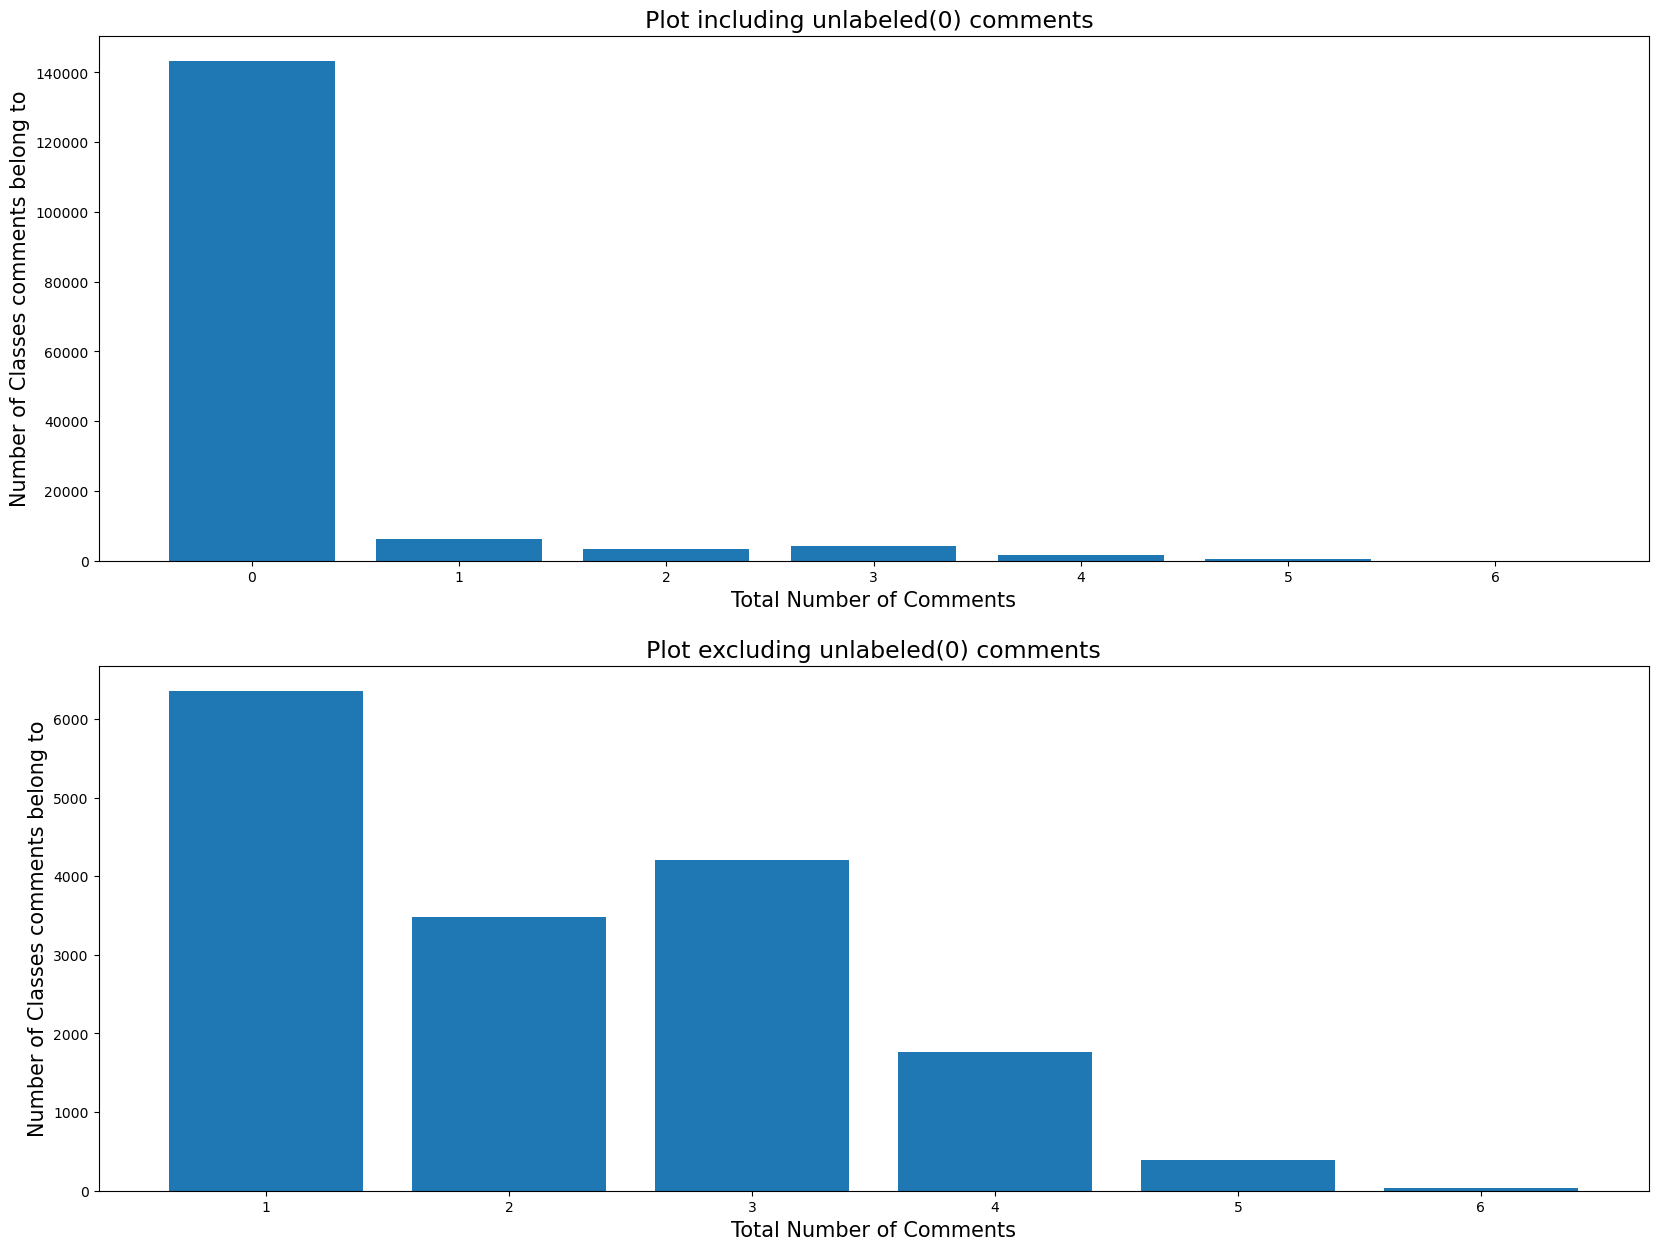

In [8]:
plt.figure(figsize=(20,15))

fr = plt.subplot(2,1,1)
plt.bar(keys,values)

fr.set_xlabel("Total Number of Comments", fontsize=15)
fr.set_ylabel("Number of Classes comments belong to", fontsize=15)
fr.set_title("Plot including unlabeled(0) comments ", fontsize=17)


se = plt.subplot(2,1,2)
plt.bar(keys1, values1)

se.set_xlabel("Total Number of Comments", fontsize=15)
se.set_ylabel("Number of Classes comments belong to", fontsize=15)
se.set_title("Plot excluding unlabeled(0) comments", fontsize=17)

Text(0.5, 1.0, 'distribution of classes without non toxic values')

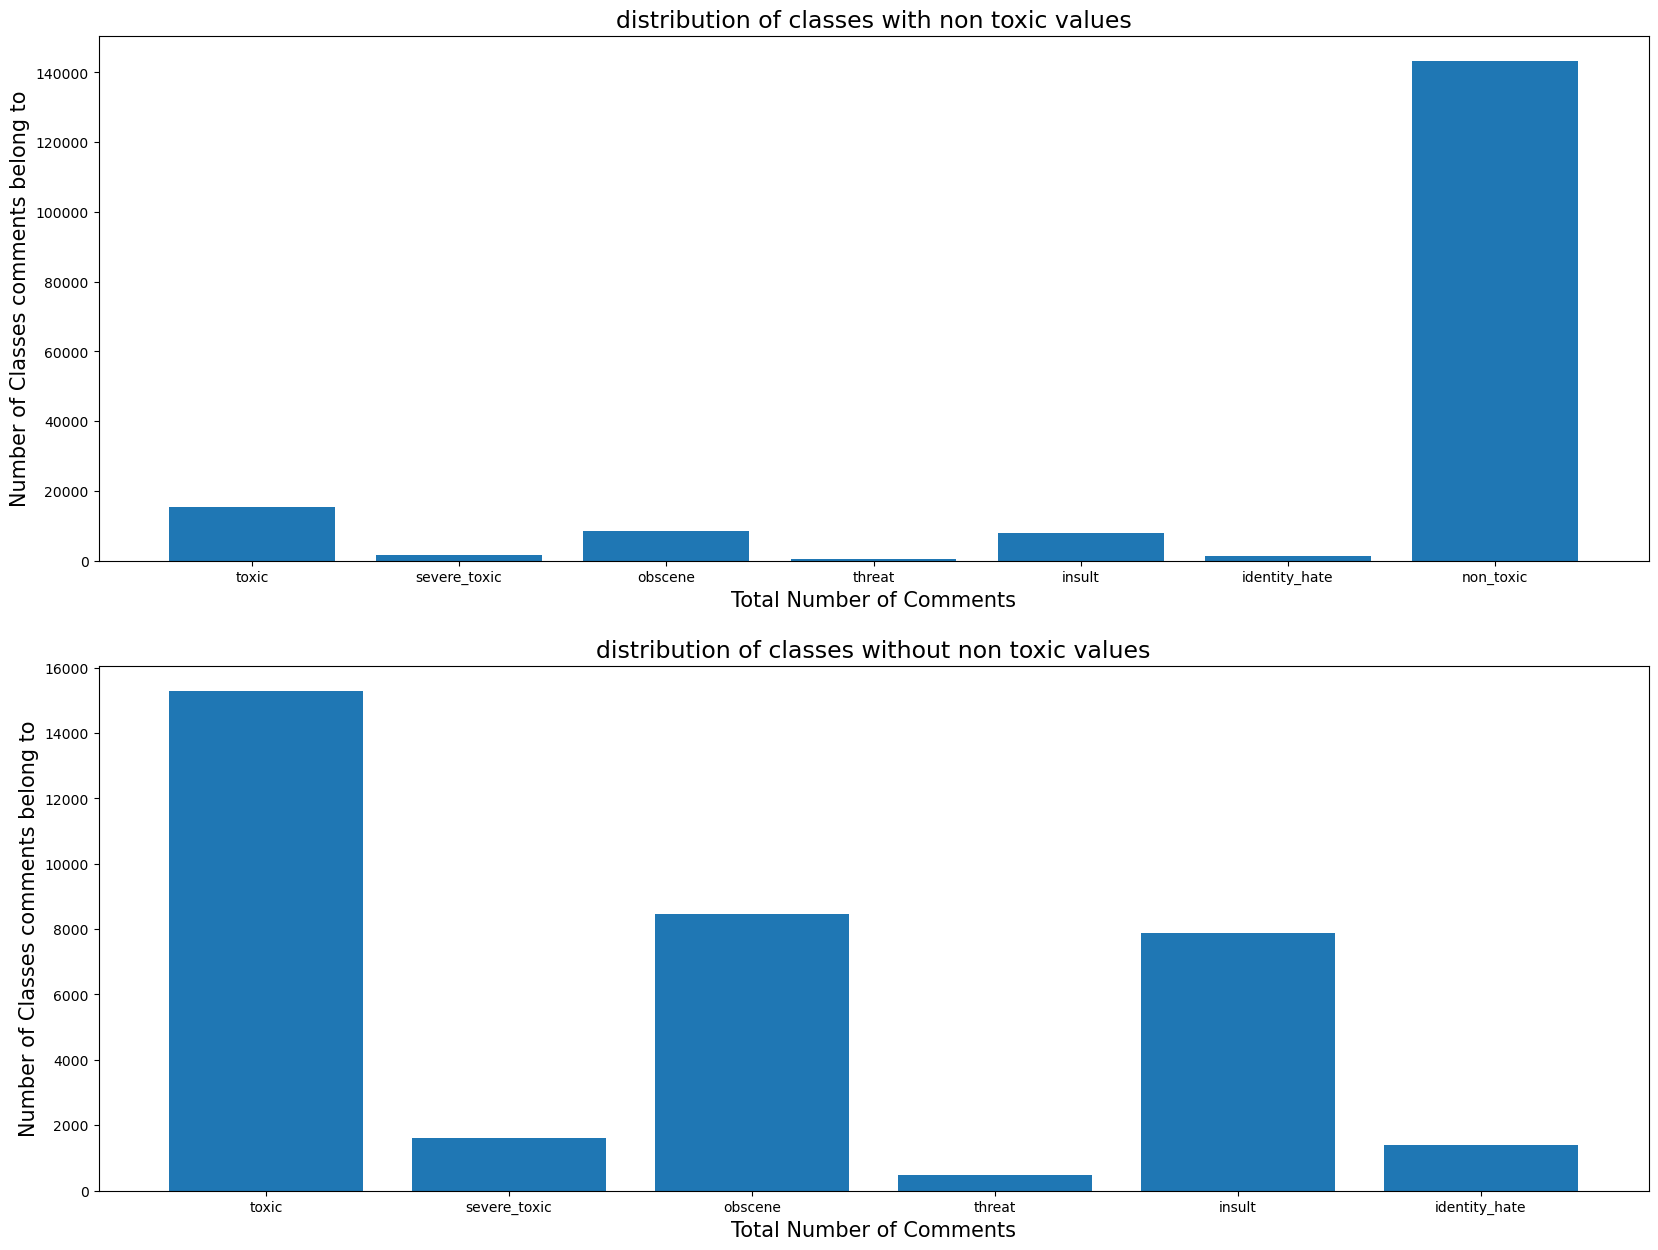

In [9]:
plt.figure(figsize=(20,15))
rude=list(total.values())

fr = plt.subplot(2,1,1)
plt.bar(x = ['toxic', 'severe_toxic', 'obscene', 'threat','insult', 'identity_hate','non_toxic'],height=total.values())

fr.set_xlabel("Total Number of Comments", fontsize=15)
fr.set_ylabel("Number of Classes comments belong to", fontsize=15)
fr.set_title("distribution of classes with non toxic values", fontsize=17)


se = plt.subplot(2,1,2)
plt.bar(x = ['toxic', 'severe_toxic', 'obscene', 'threat','insult', 'identity_hate'], height=rude[:-1])

se.set_xlabel("Total Number of Comments", fontsize=15)
se.set_ylabel("Number of Classes comments belong to", fontsize=15)
se.set_title("distribution of classes without non toxic values", fontsize=17)

In [10]:
processed_data=train_df.copy()

In [11]:
processed_data['comment_text'].tolist()

["Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27",
 "D'aww! He matches this background colour I'm seemingly stuck with. Thanks.  (talk) 21:51, January 11, 2016 (UTC)",
 "Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than the actual info.",
 '"\nMore\nI can\'t make any real suggestions on improvement - I wondered if the section statistics should be later on, or a subsection of ""types of accidents""  -I think the references may need tidying so that they are all in the exact same format ie date format etc. I can do that later on, if no-one else does first - if you have any preferences for formatting style on r

In [12]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\nisha\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [13]:
# Preprocess the text data
def preprocess(text):

    #Removing IP address
    
    text=re.sub(r"([0-9]{1,3})\.([0-9]{1,3})\.([0-9]{1,3})\.([0-9]{1,3})","",text)

    #Getting ride of the URLs with space even if they are in paranthesis 

    text=re.sub(r"\S*https?:\S*|\s*www\.\s*", "", text)

    text=re.sub(r"\"\"", "\"",text)  # replacing "" with "

    text=re.sub(r"^\"", "",text)      # removing quotation from start and the end of the string

    #Remove special characters and numbers 
    text=re.sub(r'\s*[^a-zA-Z]\s*',' ',text)

    #Removing extra spaces in the text 
    text=re.sub(r"\s\s+", " ",text)

    # Remove stopwords
    words = word_tokenize(text)
    words = [w for w in words if not w in stop_words]
    return text

In [14]:
processed_data['comment_text']=processed_data['comment_text'].apply(preprocess)

In [15]:
working_data=processed_data.copy()
#C_indexs = processed_data[processed_data["classes"]==0].index
#C_indexs.shape

In [16]:
#Keep 5000 of non_toxic comments and drop the rest
#drop_ind=np.random.choice(C_indexs, size=138346, replace=False)
#working_data.drop(drop_ind, inplace=True)


In [17]:
working_data=working_data.sample(5000)
working_data=working_data.reset_index()
working_data.drop(columns=['index','non_toxic','classes'], inplace=True)
working_data.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,43346ed16a37ce08,Huh You page protected Amanda Knox The previou...,0,0,0,0,0,0
1,af7a26ba0fe8361e,Longest city walls What about Genoa Italy for...,0,0,0,0,0,0
2,a268bd12a3f03a17,get a life do you thing only underage teeneger...,0,0,0,0,0,0
3,3b1c359fa5611192,Many The term Many implies more than half Ple...,0,0,0,0,0,0
4,af6c2fa95f19b550,Please consider a marketing plan for your prod...,0,0,0,0,0,0


In [18]:
#seperating the data into test and train sets
#from sklearn.model_selection import train_test_split

#X=working_data.iloc[:,1]
#y=working_data.iloc[:,2:8]

#X_train,X_test,y_train,y_test=train_test_split(X,y, test_size=0.3)

In [19]:
class lemmaTokenizer(object):
    def __init__(self, stop_words):
        self.stop_words = stop_words
        from nltk.stem import WordNetLemmatizer
        self.lemmatizer = WordNetLemmatizer()
    def __call__(self, doc):
        tokens = word_tokenize(doc)
        filtered_tok = []
        for tok in tokens:
            if tok not in stop_words:
                tok = re.sub('\W+','', tok) #Punctuation strip
                tmp = self.lemmatizer.lemmatize(tok)
                if len(tmp) >= 2:
                    filtered_tok.append(tmp)
        return filtered_tok

In [20]:
class stemTokenizer(object):
    def __init__(self, stop_words):
        self.stop_words = stop_words
        from nltk.stem import SnowballStemmer
        self.stemmer = SnowballStemmer(language='english')
    def __call__(self, doc):
        tokens = word_tokenize(doc)
        filtered_tok = []
        for tok in tokens:
            if tok not in stop_words:
                filtered_tok.append(self.stemmer.stem(tok))
        return filtered_tok

In [21]:
class swTokenizer(object):
    def __init__(self, stop_words):
        self.stop_words = stop_words
    def __call__(self, doc):
        tokens = word_tokenize(doc)
        filtered_tok = []
        for tok in tokens:
            if tok not in stop_words:
                filtered_tok.append(tok)
        return filtered_tok

Here we tried a range of different models 


In [22]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import classification_report, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC, LinearSVC

#TF-IDF

y = working_data.iloc[:,2:]
X = working_data["comment_text"]
vectorizer = TfidfVectorizer(sublinear_tf=True, ngram_range=(1,3), strip_accents="unicode",max_features=5000)
X = vectorizer.fit_transform(X).toarray()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [23]:


# Train a logistic regression classifier for each toxicity label
labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
for label in labels:
    y_train_label = y_train[label]
    y_test_label = y_test[label]
    model=SVC()
    model.fit(X_train, y_train_label)
    model.score(X_test, y_test_label)
    y_pred1 = model.predict(X_test)
    accuracy1 = accuracy_score(y_test_label, y_pred1)
    print(f"Accuracy score of {label}: {accuracy1}")
    print("Train Score:", model.score(X_train, y_train[label]))
    print("Test Score:", model.score(X_test, y_test[label]))

Accuracy score of toxic: 0.915
Train Score: 0.98075
Test Score: 0.915
Accuracy score of severe_toxic: 0.984
Train Score: 0.995
Test Score: 0.984
Accuracy score of obscene: 0.953
Train Score: 0.98975
Test Score: 0.953
Accuracy score of threat: 0.994
Train Score: 0.9985
Test Score: 0.994
Accuracy score of insult: 0.953
Train Score: 0.989
Test Score: 0.953
Accuracy score of identity_hate: 0.988
Train Score: 0.99425
Test Score: 0.988


In [24]:
from sklearn.decomposition import TruncatedSVD


labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
for label in labels:
    y_train_label = y_train[label]
    y_test_label = y_test[label]
    svd_tmp2 = TruncatedSVD(n_components=20)
    pipe_steps2 = [("svd", svd_tmp2), ("model", SVC())]
    pipe_test2 = Pipeline(steps=pipe_steps2)
    pipe_test2.fit(X_train, y_train_label)
    pipe_test2.score(X_test, y_test_label)
    y_pred2 = pipe_test2.predict(X_test)
    accuracy2 = accuracy_score(y_test_label, y_pred2)
    print(f"Accuracy score of {label}: {accuracy2}")
    print("Train Score:", pipe_test2.score(X_train, y_train[label]))
    print("Test Score:", pipe_test2.score(X_test, y_test[label]))


Accuracy score of toxic: 0.899
Train Score: 0.9225
Test Score: 0.899
Accuracy score of severe_toxic: 0.985
Train Score: 0.9905
Test Score: 0.985
Accuracy score of obscene: 0.943
Train Score: 0.96325
Test Score: 0.943
Accuracy score of threat: 0.994
Train Score: 0.9985
Test Score: 0.994
Accuracy score of insult: 0.949
Train Score: 0.96375
Test Score: 0.949
Accuracy score of identity_hate: 0.988
Train Score: 0.99275
Test Score: 0.988


In [25]:
from sklearn.ensemble import RandomForestClassifier

labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
for label in labels:
    y_train_label = y_train[label]
    y_test_label = y_test[label]
    svd_tmp3 = TruncatedSVD(n_components=20)
    pipe_steps3 =[ ('svd', svd_tmp3), ('m', RandomForestClassifier())]
    pipe_test3 = Pipeline(steps=pipe_steps3)
    pipe_test3.fit(X_train, y_train_label)
    pipe_test3.score(X_test, y_test_label)
    y_pred3 = pipe_test3.predict(X_test)
    accuracy3 = accuracy_score(y_test_label, y_pred3)
    print(f"Accuracy score of {label}: {accuracy3}")
    print("Train Score:", pipe_test3.score(X_train, y_train[label]))
    print("Test Score:", pipe_test3.score(X_test, y_test[label]))

Accuracy score of toxic: 0.901
Train Score: 0.99975
Test Score: 0.901
Accuracy score of severe_toxic: 0.984
Train Score: 1.0
Test Score: 0.984
Accuracy score of obscene: 0.944
Train Score: 0.99975
Test Score: 0.944
Accuracy score of threat: 0.994
Train Score: 1.0
Test Score: 0.994
Accuracy score of insult: 0.948
Train Score: 0.99975
Test Score: 0.948
Accuracy score of identity_hate: 0.988
Train Score: 1.0
Test Score: 0.988


In [26]:
labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
for label in labels:
    y_train_label = y_train[label]
    y_test_label = y_test[label]
    clf4 = LogisticRegression()
    clf4.fit(X_train, y_train_label)
    y_pred4 = clf4.predict(X_test)
    accuracy4 = accuracy_score(y_test_label, y_pred4)
    print(f"Accuracy score of {label}: {accuracy4}")
    print("Train Score:", clf4.score(X_train, y_train[label]))
    print("Test Score:", clf4.score(X_test, y_test[label]))


Accuracy score of toxic: 0.909
Train Score: 0.93475
Test Score: 0.909
Accuracy score of severe_toxic: 0.985
Train Score: 0.9905
Test Score: 0.985
Accuracy score of obscene: 0.948
Train Score: 0.9665
Test Score: 0.948
Accuracy score of threat: 0.994
Train Score: 0.9985
Test Score: 0.994
Accuracy score of insult: 0.951
Train Score: 0.9655
Test Score: 0.951
Accuracy score of identity_hate: 0.988
Train Score: 0.99275
Test Score: 0.988


In [27]:
train_df=pd.read_csv("train.csv.zip")
train_df['comment_text']=train_df['comment_text'].apply(preprocess)

In [28]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

#TF-IDF

y = working_data.iloc[:,2:]
X = working_data["comment_text"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [29]:
from sklearn.metrics import confusion_matrix
import seaborn as sns


labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
classifiers = {}
for label in labels:
    y_train_label = y_train[label]
    y_test_label = y_test[label]
    model7=RandomForestClassifier()
    svd_tmp7 = TruncatedSVD(n_components=20)
    vec_tf7 = TfidfVectorizer(sublinear_tf=True, ngram_range=(1,3), strip_accents="unicode")
    pipe7 = Pipeline([
                    ("vect", vec_tf7),
                    ('svd', svd_tmp3),
                    ("model", model7)])
    
    params7 = {"vect__max_features":[100,500,1000,1500,2000,2500],
            "vect__tokenizer":(swTokenizer(stop_words), stemTokenizer(stop_words), lemmaTokenizer(stop_words) ),
            "vect__norm":["l1","l2"]}

    clf7 = GridSearchCV(estimator  = pipe7, param_grid = params7, scoring= "balanced_accuracy",
                               cv= 5,n_jobs=-1)
    clf7.fit(X_train, y_train_label)
    y_pred7 = clf7.predict(X_test)
    accuracy = accuracy_score(y_test_label, y_pred7)
    print(f"Accuracy score of {label}: {accuracy}")
    print("Train Score:", clf7.score(X_train, y_train[label]))
    print("Test Score:", clf7.score(X_test, y_test[label]))
    classifiers[label]=clf7

Accuracy score of toxic: 0.931
Train Score: 0.9914529914529915
Test Score: 0.7063309408644094
Accuracy score of severe_toxic: 0.985
Train Score: 0.9998738011105502
Test Score: 0.6641285956006768
Accuracy score of obscene: 0.962
Train Score: 0.9719101123595506
Test Score: 0.7447656408100998
Accuracy score of threat: 0.992
Train Score: 0.75
Test Score: 0.49899396378269617


In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns


labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
classifiers = {}
for label in labels:
    y_train_label = y_train[label]
    y_test_label = y_test[label]
    model8=LogisticRegression()
    svd_tmp8 = TruncatedSVD(n_components=20)
    vec_tf8 = TfidfVectorizer(sublinear_tf=True, ngram_range=(1,3), strip_accents="unicode")
    pipe8 = Pipeline([
                    ("vect", vec_tf8),
                    ('svd', svd_tmp8),
                    ("model", model8)])
    
    params8 = {"vect__max_features":[100,500,1000,1500,2000,2500],
            "vect__tokenizer":(swTokenizer(stop_words), stemTokenizer(stop_words), lemmaTokenizer(stop_words) ),
            "vect__norm":["l1","l2"]}

    clf8 = GridSearchCV(estimator  = pipe8, param_grid = params8, scoring= "balanced_accuracy",
                               cv= 5,n_jobs=-1)
    clf8.fit(X_train, y_train_label)
    y_pred8 = clf8.predict(X_test)
    accuracy8 = accuracy_score(y_test_label, y_pred8)
    print(f"Accuracy score of {label}: {accuracy}")
    print("Train Score:", clf8.score(X_train, y_train[label]))
    print("Test Score:", clf8.score(X_test, y_test[label]))
    classifiers[label]=clf8

Accuracy score of toxic: 0.989
Train Score: 0.6191577603006823
Test Score: 0.6105263157894737
Accuracy score of severe_toxic: 0.989
Train Score: 0.5
Test Score: 0.5
Accuracy score of obscene: 0.989
Train Score: 0.6892933777541546
Test Score: 0.6909647027304593
Accuracy score of threat: 0.989
Train Score: 0.5
Test Score: 0.5
Accuracy score of insult: 0.989
Train Score: 0.6220023384549702
Test Score: 0.5862710878417685
Accuracy score of identity_hate: 0.989
Train Score: 0.5
Test Score: 0.5


In [ ]:
labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
classifiers = {}
for label in labels:
    y_train_label = y_train[label]
    y_test_label = y_test[label]
    model9=SVC()
    svd_tmp9 = TruncatedSVD(n_components=20)
    vec_tf9 = TfidfVectorizer(sublinear_tf=True, ngram_range=(1,3), strip_accents="unicode")
    pipe9 = Pipeline([
                    ("vect", vec_tf8),
                    ('svd', svd_tmp8),
                    ("model", model8)])
    
    params9 = {"vect__max_features":[100,500,1000,1500,2000,2500],
            "vect__tokenizer":(swTokenizer(stop_words), stemTokenizer(stop_words), lemmaTokenizer(stop_words) ),
            "vect__norm":["l1","l2"]}

    clf9 = GridSearchCV(estimator  = pipe9, param_grid = params9, scoring= "balanced_accuracy",
                               cv= 5,n_jobs=-1)
    clf9.fit(X_train, y_train_label)
    y_pred9 = clf9.predict(X_test)
    accuracy9 = accuracy_score(y_test_label, y_pred9)
    print(f"Accuracy score of {label}: {accuracy}")
    print("Train Score:", clf9.score(X_train, y_train[label]))
    print("Test Score:", clf9.score(X_test, y_test[label]))
    classifiers[label]=clf9

Accuracy score of toxic: 0.989
Train Score: 0.6215790678067354
Test Score: 0.6105263157894737
Accuracy score of severe_toxic: 0.989
Train Score: 0.5
Test Score: 0.5
Accuracy score of obscene: 0.989
Train Score: 0.6849265655270804
Test Score: 0.6909647027304593
Accuracy score of threat: 0.989
Train Score: 0.5
Test Score: 0.5
Accuracy score of insult: 0.989
Train Score: 0.6264572892358298
Test Score: 0.6196044211751018
Accuracy score of identity_hate: 0.989
Train Score: 0.5
Test Score: 0.5


For text pre-processing,the following steps were taken:

    1.Elimination of IP addresses, URLs, blank spaces, quotation marks, special characters, extra spaces, and stop words

	2.Stemming and lemmatization were applied to improve text normalization

As for the imbalanced target, random over-sampling was attempted, but no improvement in accuracy was observed.
For vectorization, count vectorization was found to be ineffective, and thus the Tf-Idf vectorization method was utilized.
In the modeling stage, several models were tested including Logistic Regression, SVC, and Random Forest Classifier, with truncated SVD. The accuracies of each model were evaluated, and the SVC with truncated SVD was chosen as the most effective model.

## Test Data

In [ ]:
test_df = pd.read_csv("test.csv")
test_df.head()

,id,comment_text
0,1,Yo bitch Ja Rule is more succesful then you'll...
1,2,== From RfC == \n\n The title is fine as it is...
2,3,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,4,":If you have a look back at the source, the in..."
4,5,I don't anonymously edit articles at all.


## Output Details, Submission Info, and Example Submission

For this project, please output your predictions in a CSV file. The structure of the CSV file should match the structure of the example below. 

The output should contain one row for each row of test data, complete with the columns for ID and each classification.

Into Moodle please submit:
<ul>
<li> Your notebook file(s). I'm not going to run them, just look. 
<li> Your sample submission CSV. This will be evaluated for accuracy against the real labels; only a subset of the predictions will be scored. 
</ul>

It is REALLY, REALLY, REALLY important the the structure of your output matches the specifications. The accuracies will be calculated by a script, and it is expecting a specific format. 

### Sample Evaluator

The file prediction_evaluator.ipynb contains an example scoring function, scoreChecker. This function takes a sumbission and an answer key, loops through, and evaluates the accuracy. You can use this to verify the format of your submission. I'm going to use the same function to evaluate the accuracy of your submission, against the answer key (unless I made some mistake in this counting function).

In [ ]:
test_df['comment_text'] = test_df['comment_text'].apply(preprocess)

In [ ]:
# Predict the toxicity labels for the test data using the trained classifiers
pred_labels = {}
for label in labels:
    clf8 = classifiers[label]
    pred_labels[label] = clf8.predict(X_test)

    

In [ ]:
out_df = pd.DataFrame(pred_labels, columns=labels)

In [ ]:
out_df['id']=test_df['id']

In [ ]:
# Store the predicted labels in a file named out.csv
out_df.to_csv('out.csv', index=False)

## Grading

The grading for this is split between accuracy and well written code:
<ul>
<li> 75% - Accuracy. The most accurate will get 100% on this, the others will be scaled down from there. 
<li> 25% - Code quality. Can the code be followed and made sense of - i.e. comments, sections, titles. 
</ul>